 - We used CVXPY package along with MOSEK solver in the paper.

- To install CVXPY and MOSEK:

pip install cvxpy
pip install mosek
Note that you will need the MOSEK license. You can request a free academic license if you are a student or faculty. For license issues, please check the instruction here.
You could also use other installed solvers in CVXPY, however the results would be quite different. We found that MOSEK solver is stable numerically and runs faster than other packages.

In [ ]:
import cvxpy as cp
import numpy as np
import math

from matplotlib import pyplot as plt

In [2]:
def init_plotting():
  plt.rcParams['figure.figsize'] = (8, 5.5)
  plt.rcParams['pdf.fonttype'] = 42
  plt.rcParams['font.size'] = 18
  plt.rcParams['axes.labelsize'] = 1.2 * plt.rcParams['font.size']
  plt.rcParams['axes.titlesize'] = 1.5 * plt.rcParams['font.size']
  plt.rcParams['legend.fontsize'] = 1.2 * plt.rcParams['font.size']
  plt.rcParams['xtick.labelsize'] = 1.2 * plt.rcParams['font.size']
  plt.rcParams['ytick.labelsize'] = 1.2 * plt.rcParams['font.size']
  plt.rcParams["legend.framealpha"] = 0.7
  plt.rcParams['lines.linewidth'] = 2.5
  plt.rcParams['lines.markersize'] = 10

init_plotting()

In [3]:
def search_minimax_optimal_rate_alt_gda(L, m, eta, max_iter=50):
  rho_opt = 0.0
  for _ in range(1):
    B = np.random.randn(1, 1)
    e, _ = np.linalg.eig(B.T @ B)
    B = B / np.max(e ** 0.5) * L

    rho_min = 0.0
    rho_max = 1.0

    # define matrices
    iden = np.eye(np.shape(B)[0])
    zero = np.zeros_like(B)
    A = np.block([[iden, -eta * B], [eta * B.T, iden - eta ** 2 * B.T @ B]])
    B = np.block([[-eta * iden, zero], [-eta ** 2 * B.T, -eta * iden]])
    A_hat = np.block([[A, np.zeros_like(A)], [-L * np.eye(np.shape(A)[0]), np.zeros_like(A)]])
    B_hat = np.block([[B], [np.eye(np.shape(B)[0])]])

    C1 = np.block([[L * np.eye(np.shape(A)[0]), np.zeros_like(A)], 
                   [-m * np.eye(np.shape(A)[0]), np.zeros_like(A)]])
    D1 = np.block([[-np.eye(np.shape(A)[0])], [np.eye(np.shape(A)[0])]])

    C2 = np.block([[L * np.eye(np.shape(A)[0]), np.eye(np.shape(A)[0])], 
                   [-m * np.eye(np.shape(A)[0]), np.zeros_like(A)]])
    D2 = np.block([[-np.eye(np.shape(A)[0])], [np.eye(np.shape(A)[0])]])

    M1 = np.block([[zero, zero, iden, zero], [zero, zero, zero, zero],
                 [iden, zero, zero, zero], [zero, zero, zero, zero]])
    M2 = np.block([[zero, zero, zero, zero], [zero, zero, zero, iden],
                 [zero, zero, zero, zero], [zero, iden, zero, zero]])

    CM11 = np.concatenate((C1, D1), axis=1).T @ M1 @ np.concatenate((C1, D1), axis=1)
    CM12 = np.concatenate((C1, D1), axis=1).T @ M2 @ np.concatenate((C1, D1), axis=1)
    CM21 = np.concatenate((C2, D2), axis=1).T @ M1 @ np.concatenate((C2, D2), axis=1)
    CM22 = np.concatenate((C2, D2), axis=1).T @ M2 @ np.concatenate((C2, D2), axis=1)

    for itr in range(max_iter):
      rho = (rho_max + rho_min) * 0.5

      # Define and solve the CVXPY problem.
      # Create a symmetric matrix variable.
      P = cp.Variable((4,4), symmetric=True)
      lam11 = cp.Variable(1, nonneg=True)
      lam12 = cp.Variable(1, nonneg=True)
      lam21 = cp.Variable(1, nonneg=True)
      lam22 = cp.Variable(1, nonneg=True)

      # The operator >> denotes matrix inequality.
      constraints = [lam11 == 1] # breaking homogeneity
      constraints += [P >> 0]
      constraints += [lam12 <= rho * (lam11 + lam12)]
      constraints += [lam22 <= rho * (lam21 + lam22)]
      constraints += [cp.bmat([[A_hat.T @ P @ A_hat - rho * P, A_hat.T @ P @ B_hat], [B_hat.T @ P @ A_hat, B_hat.T @ P @ B_hat]]) 
                      + lam11 * CM11 + lam12 * CM12 + lam21 * CM21 + lam22 * CM22 << 0]

      # choose an arbitary objective to minimize
      prob = cp.Problem(cp.Minimize(cp.trace(P)), constraints=constraints)
      mosek_params = {
            "MSK_DPAR_BASIS_TOL_X": 1e-9,
            "MSK_DPAR_BASIS_TOL_S": 1e-9,
            "MSK_DPAR_BASIS_REL_TOL_S": 1e-15,
            "MSK_IPAR_INTPNT_MAX_ITERATIONS": 1000000,
            "MSK_DPAR_SEMIDEFINITE_TOL_APPROX": 1e-15,
            "MSK_DPAR_PRESOLVE_TOL_X": 1e-12,
            "MSK_DPAR_INTPNT_CO_TOL_DFEAS": 1e-9,
            "MSK_DPAR_INTPNT_CO_TOL_PFEAS": 1e-9,
            "MSK_DPAR_INTPNT_CO_TOL_REL_GAP": 1e-9
      }
      try:
        prob.solve(solver=cp.MOSEK, mosek_params=mosek_params)
      except:
        rho_min = rho
        continue

      if 'optimal' in prob.status:
        rho_max = rho
      else:
        rho_min = rho
    rho_opt = max(rho_opt, rho_max)
  return rho_opt

In [4]:
def search_minimax_optimal_rate_sim_gda(L, m, eta, max_iter=50):
  rho_opt = 0.0
  for _ in range(1):
    B = np.random.randn(1, 1)
    e, _ = np.linalg.eig(B.T @ B)
    B = B / np.max(e ** 0.5) * L

    rho_min = 0.0
    rho_max = 1.0

    # define matrices
    iden = np.eye(np.shape(B)[0])
    zero = np.zeros_like(B)
    A = np.block([[iden, -eta * B], [eta * B.T, iden]])
    B = np.block([[-eta * iden, zero], [zero, -eta * iden]])
    A_hat = np.block([[A, np.zeros_like(A)], [-L * np.eye(np.shape(A)[0]), np.zeros_like(A)]])
    B_hat = np.block([[B], [np.eye(np.shape(B)[0])]])

    C1 = np.block([[L * np.eye(np.shape(A)[0]), np.zeros_like(A)], 
                   [-m * np.eye(np.shape(A)[0]), np.zeros_like(A)]])
    D1 = np.block([[-np.eye(np.shape(A)[0])], [np.eye(np.shape(A)[0])]])

    C2 = np.block([[L * np.eye(np.shape(A)[0]), np.eye(np.shape(A)[0])], 
                   [-m * np.eye(np.shape(A)[0]), np.zeros_like(A)]])
    D2 = np.block([[-np.eye(np.shape(A)[0])], [np.eye(np.shape(A)[0])]])

    M1 = np.block([[zero, zero, iden, zero], [zero, zero, zero, zero],
                 [iden, zero, zero, zero], [zero, zero, zero, zero]])
    M2 = np.block([[zero, zero, zero, zero], [zero, zero, zero, iden],
                 [zero, zero, zero, zero], [zero, iden, zero, zero]])

    CM11 = np.concatenate((C1, D1), axis=1).T @ M1 @ np.concatenate((C1, D1), axis=1)
    CM12 = np.concatenate((C1, D1), axis=1).T @ M2 @ np.concatenate((C1, D1), axis=1)
    CM21 = np.concatenate((C2, D2), axis=1).T @ M1 @ np.concatenate((C2, D2), axis=1)
    CM22 = np.concatenate((C2, D2), axis=1).T @ M2 @ np.concatenate((C2, D2), axis=1)

    for itr in range(max_iter):
      rho = (rho_max + rho_min) * 0.5

      # Define and solve the CVXPY problem.
      # Create a symmetric matrix variable.
      P = cp.Variable((4,4), symmetric=True)
      lam11 = cp.Variable(1, nonneg=True)
      lam12 = cp.Variable(1, nonneg=True)
      lam21 = cp.Variable(1, nonneg=True)
      lam22 = cp.Variable(1, nonneg=True)

      # The operator >> denotes matrix inequality.
      constraints = [lam11 == 1] # breaking homogeneity
      constraints += [P >> 0]
      constraints += [lam12 <= rho * (lam11 + lam12)]
      constraints += [lam22 <= rho * (lam21 + lam22)]
      constraints += [cp.bmat([[A_hat.T @ P @ A_hat - rho * P, A_hat.T @ P @ B_hat], [B_hat.T @ P @ A_hat, B_hat.T @ P @ B_hat]]) 
                      + lam11 * CM11 + lam12 * CM12 + lam21 * CM21 + lam22 * CM22 << 0]

      # choose an arbitary objective to minimize
      prob = cp.Problem(cp.Minimize(cp.trace(P)), constraints=constraints)
      mosek_params = {
            "MSK_DPAR_BASIS_TOL_X": 1e-9,
            "MSK_DPAR_BASIS_TOL_S": 1e-9,
            "MSK_DPAR_BASIS_REL_TOL_S": 1e-15,
            "MSK_IPAR_INTPNT_MAX_ITERATIONS": 1000000,
            "MSK_DPAR_SEMIDEFINITE_TOL_APPROX": 1e-15,
            "MSK_DPAR_PRESOLVE_TOL_X": 1e-12,
            "MSK_DPAR_INTPNT_CO_TOL_DFEAS": 1e-9,
            "MSK_DPAR_INTPNT_CO_TOL_PFEAS": 1e-9,
            "MSK_DPAR_INTPNT_CO_TOL_REL_GAP": 1e-9
      }
      try:
        prob.solve(solver=cp.MOSEK, mosek_params=mosek_params)
      except:
        rho_min = rho
        continue

      if 'optimal' in prob.status:
        rho_max = rho
      else:
        rho_min = rho
    rho_opt = max(rho_opt, rho_max)
  return rho_opt

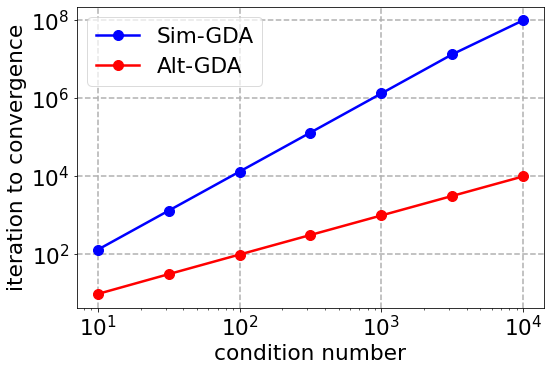

In [5]:
L = 1.0

iter_list_alt, iter_list_sim = [], []
for m in np.logspace(-4, -1, num=7):
#     eta_factors = np.logspace(0.0, math.log10(m)-1, num=30)
    eta_factors = [0.5]
    best_rho_alt = best_rho_sim = 1 - 10 ** (-8)
    best_eta_alt = best_eta_sim = 0.0
    for eta_factor in eta_factors:
        eta = 1 / L * eta_factor
        rho_alt = search_minimax_optimal_rate_alt_gda(L, m, eta)
        rho_sim = search_minimax_optimal_rate_sim_gda(L, m, eta * m)
        if rho_alt < best_rho_alt:
            best_rho_alt = rho_alt
            best_eta_alt = eta
        if rho_sim < best_rho_sim:
            best_rho_sim = rho_sim
            best_eta_sim = eta
    iter_list_alt.append(-1.0 / math.log(best_rho_alt))
    iter_list_sim.append(-1.0 / math.log(best_rho_sim))
                                                
plt.figure(1)
plt.plot(np.logspace(4, 1, num=7), iter_list_sim, color='b', linestyle='solid', marker='o', label='Sim-GDA')
plt.plot(np.logspace(4, 1, num=7), iter_list_alt, color='r', linestyle='solid', marker='o', label='Alt-GDA')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(linestyle='--', linewidth=1.5)
plt.xlabel('condition number')
plt.ylabel('iteration to convergence')
plt.tight_layout()